<a href="https://colab.research.google.com/github/Shivansh-datascience/Mumbai_power_demand_forecasting/blob/main/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mumbai Power demand Forecasting

downloading all packages required

In [70]:
import pandas as pd
import numpy as np
from pyspark.sql.session import SparkSession
import warnings
warnings.filterwarnings(action='ignore')   #ignoring all the warnings message

#adding some visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

#adding the packages for demand forecasting
import scipy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.tree import DecisionTreeRegressor , plot_tree
from sklearn.ensemble import RandomForestRegressor


#adding the evaluation metrics
from sklearn.metrics import mean_squared_error , mean_absolute_error , r2_score


import joblib , pickle

importing the CSV file through colab Environment

In [71]:
#imprting the csv file through SparkSession
try:
  CSV_file_session = SparkSession.builder.appName('Reading CSV File').getOrCreate()
except Exception as e:
  print(f" {e} creating in SparkSession")
finally:
  print(f" Spark Session builded :  {CSV_file_session}")

 Spark Session builded :  <pyspark.sql.session.SparkSession object at 0x78875be6ab50>


with the help of spark Session fetching the CSV file

In [72]:
#initializing the CSV file path
csv_file_path = '/content/dataset.csv'

#reading the contents of csv file through SparkSession created
csv_file_schema = CSV_file_session.read.csv(csv_file_path , header=True , inferSchema=True)
print(csv_file_schema.printSchema())

#converting this schemas into pandas Dataframe
demand_df = csv_file_schema.toPandas()
print(demand_df.head(5))   #view on top 5 results

root
 |-- _c0: integer (nullable = true)
 |-- States: string (nullable = true)
 |-- Regions: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- Dates: string (nullable = true)
 |-- Usage: double (nullable = true)

None
   _c0       States Regions   latitude  longitude                Dates  Usage
0    0  Maharashtra      WR  19.250232  73.160175  02/01/2019 00:00:00  428.6
1    1  Maharashtra      WR  19.250232  73.160175  03/01/2019 00:00:00  419.6
2    2  Maharashtra      WR  19.250232  73.160175  04/01/2019 00:00:00  395.8
3    3  Maharashtra      WR  19.250232  73.160175  05/01/2019 00:00:00  411.1
4    4  Maharashtra      WR  19.250232  73.160175  06/01/2019 00:00:00  408.6


basic description of Dataset

In [73]:
print(f" Memory used by each columns in dataset : {demand_df.memory_usage(deep=True)}")
print(f" Memory used by enuire dataset :  {demand_df.memory_usage(deep=True).sum()}")

print(f" Size of colmns in dataset : {demand_df.size}")
print(f" number of rows and columns in dataset : {demand_df.shape}")
print(f" number of rows in dataset : {demand_df.shape[0]}")
print(f" number of columns in dataset : {demand_df.shape[1]}")

 Memory used by each columns in dataset : Index          132
_c0           2012
States       34204
Regions      29677
latitude      4024
longitude     4024
Dates        38228
Usage         4024
dtype: int64
 Memory used by enuire dataset :  116325
 Size of colmns in dataset : 3521
 number of rows and columns in dataset : (503, 7)
 number of rows in dataset : 503
 number of columns in dataset : 7


identifying the null values and duplicated values

In [74]:
def identify_null_values(demand_df):
  null_count = demand_df.isnull().sum()
  return null_count

def identify_duplicate_values(demand_df):
  duplicate_count = demand_df.duplicated().sum()
  return duplicate_count

#identifying the null count with function
null_count = identify_null_values(demand_df)
duplicate_count = identify_duplicate_values(demand_df)

print(f" number of null values in dataset : {null_count}")
print(f" number of duplicate values in dataset : {duplicate_count}")

 number of null values in dataset : _c0          0
States       0
Regions      0
latitude     0
longitude    0
Dates        0
Usage        0
dtype: int64
 number of duplicate values in dataset : 0


Descriptive statistics and summary for dataset

In [75]:
#calculating the descriptive statistics
demand_df.describe(percentiles=None)
print(demand_df.describe())
print(demand_df.info())


#saving this descriptive test in csv file
demand_df.describe().to_csv('demand_df_describe.csv')

              _c0      latitude     longitude       Usage
count  503.000000  5.030000e+02  5.030000e+02  503.000000
mean   251.000000  1.925023e+01  7.316017e+01  431.570179
std    145.347859  5.334376e-14  7.112501e-14   42.252273
min      0.000000  1.925023e+01  7.316017e+01  305.600000
25%    125.500000  1.925023e+01  7.316017e+01  401.700000
50%    251.000000  1.925023e+01  7.316017e+01  429.000000
75%    376.500000  1.925023e+01  7.316017e+01  463.750000
max    502.000000  1.925023e+01  7.316017e+01  522.100000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   _c0        503 non-null    int32  
 1   States     503 non-null    object 
 2   Regions    503 non-null    object 
 3   latitude   503 non-null    float64
 4   longitude  503 non-null    float64
 5   Dates      503 non-null    object 
 6   Usage      503 non-null    float64
dtypes: float6

handling the Data Inconsistenacy with assigning the proper data type and renaming the columns

In [76]:
#renaming the columns
demand_df.rename(columns={'_c0':'index'},inplace=True)
print(demand_df.columns)

#changing the datatype of Dates
demand_df['Dates'] = pd.to_datetime(demand_df['Dates'],format="%d/%m/%Y %H:%M:%S")

print(demand_df.info())
demand_df['time_stamp'] = demand_df['Dates'].dt.time
demand_df['hours'] = demand_df['Dates'].dt.hour
demand_df['day'] = demand_df['Dates'].dt.day
demand_df['month'] = demand_df['Dates'].dt.month
demand_df['year'] = demand_df['Dates'].dt.year
demand_df['min'] = demand_df['Dates'].dt.minute
demand_df['dayofweek'] = demand_df['Dates'].dt.dayofweek

Index(['index', 'States', 'Regions', 'latitude', 'longitude', 'Dates',
       'Usage'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   index      503 non-null    int32         
 1   States     503 non-null    object        
 2   Regions    503 non-null    object        
 3   latitude   503 non-null    float64       
 4   longitude  503 non-null    float64       
 5   Dates      503 non-null    datetime64[ns]
 6   Usage      503 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int32(1), object(2)
memory usage: 25.7+ KB
None


In [77]:
#dropping the index columns
demand_df.drop(columns=['index'],inplace=True)
print(demand_df.columns)

Index(['States', 'Regions', 'latitude', 'longitude', 'Dates', 'Usage',
       'time_stamp', 'hours', 'day', 'month', 'year', 'min', 'dayofweek'],
      dtype='object')


# Exploring Dataset

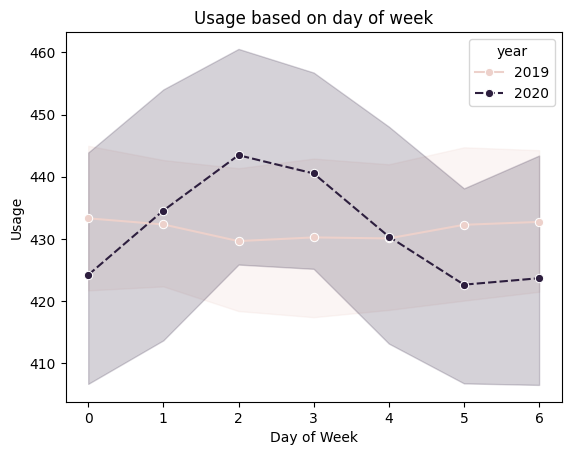

In [22]:
#plotting the linear graph for usage based on day of week of each year
sns.lineplot(x='dayofweek',y='Usage',data=demand_df,color='red',marker='o',hue='year',style='year')
plt.xlabel('Day of Week')
plt.ylabel('Usage')
plt.title('Usage based on day of week')
plt.savefig('usage_dayofweek.png')
plt.show()

from above observation we can conclude that there has been increase in power usage at mid day of week and then decrease

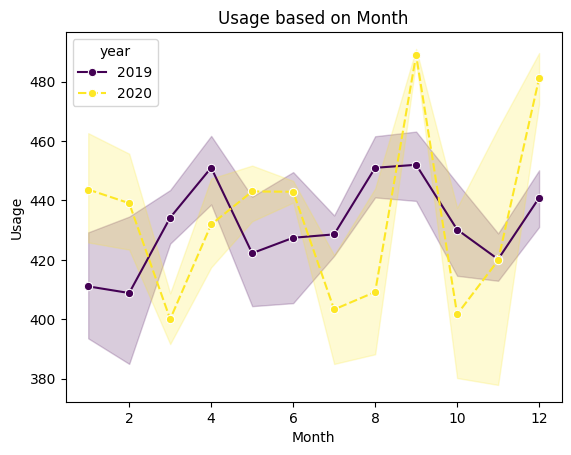

In [ ]:
#month wise power usage for each year
sns.lineplot(x='month',y='Usage',data=demand_df,color='red',marker='o',hue='year',style='year',palette='viridis')
plt.xlabel('Month')
plt.ylabel('Usage')
plt.title('Usage based on Month')
plt.savefig('usage_month.png')
plt.show()

In [9]:
#state wise highest avergae usage
state_wise_average_usage = demand_df.groupby('States')['Usage'].mean().sort_values(ascending=False)
print(state_wise_average_usage)

States
Maharashtra    431.570179
Name: Usage, dtype: float64


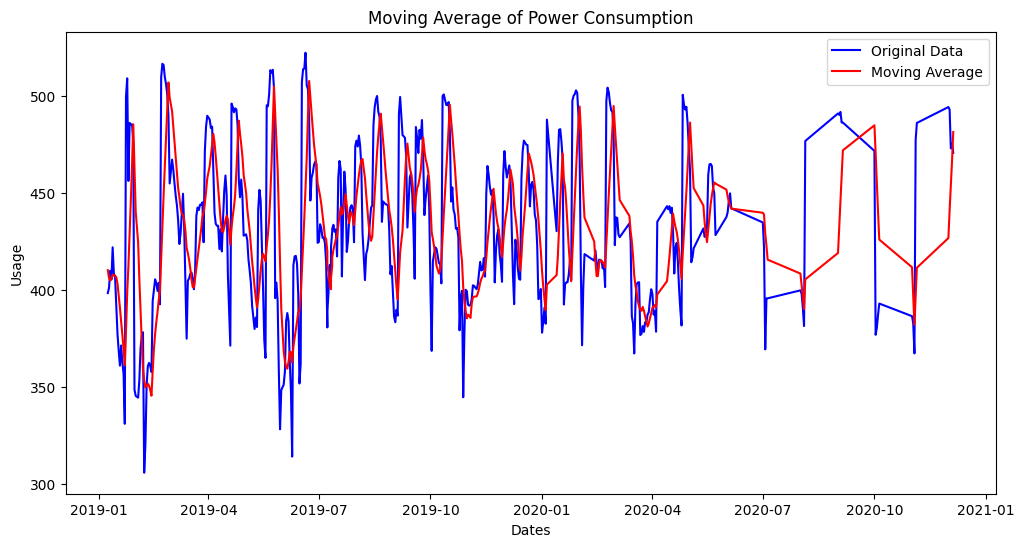

In [10]:
#calcultimg the moving averages of pwoer consumption
window_size = 7

demand_df['moving_average'] = demand_df['Usage'].rolling(window=window_size).mean()
demand_df.dropna(inplace=True)

#plotting the moving averages
plt.figure(figsize=(12,6))
plt.plot(demand_df['Dates'],demand_df['Usage'],label='Original Data',color='blue')
plt.plot(demand_df['Dates'],demand_df['moving_average'],label='Moving Average',color='red')
plt.xlabel('Dates')
plt.ylabel('Usage')
plt.title('Moving Average of Power Consumption')
plt.legend()
plt.savefig('moving_average.png')
plt.show()

Text(0.5, 1.0, 'Usage based on Day')

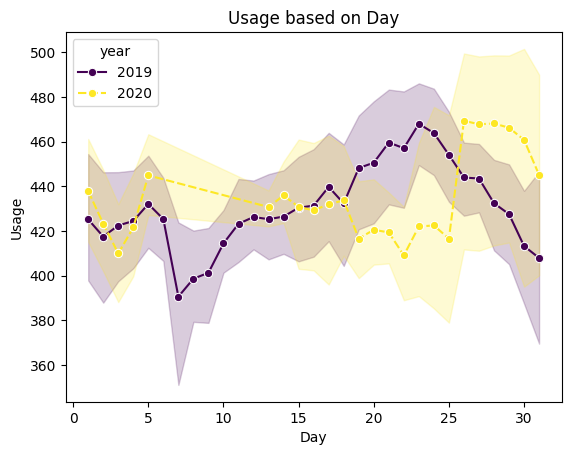

In [12]:
#let see the day wise power usage consumption
sns.lineplot(x='day',y='Usage',data=demand_df,color='red',marker='o',hue='year',style='year',palette='viridis')
plt.xlabel('Day')
plt.ylabel('Usage')
plt.title('Usage based on Day')

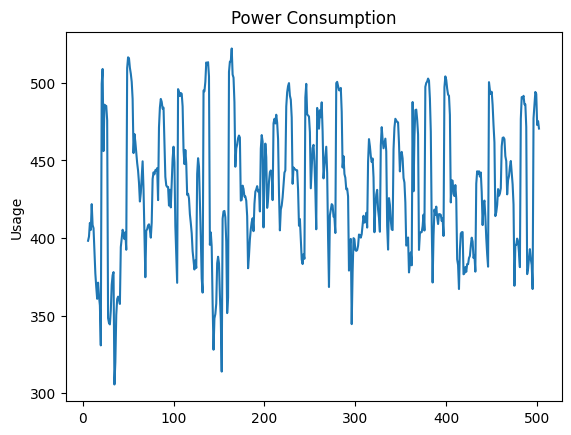

In [17]:
#plotting the consumption power
plt.plot(demand_df['Usage'])
plt.ylabel('Usage')
plt.title('Power Consumption')
plt.savefig('power_consumption.png')
plt.show()

In [78]:
#checking whether the consumption is stationary or not by ADF testing
significance_value = 0.05

def check_adf_test(demand_df):
  result = adfuller(demand_df['Usage'])
  return result[1]

p_value = check_adf_test(demand_df)
if p_value <= significance_value:
  print("The data is stationary")
else:
  print("The data is not stationary")

The data is stationary


building arima model for forecasting the consumption

In [79]:
#building an arima model
ARIMA_MODEL = ARIMA(demand_df['Usage'],order=(1,1,1))
model_fit = ARIMA_MODEL.fit() #fitting the Power Consumption variable

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Usage   No. Observations:                  503
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2348.835
Date:                Sat, 01 Mar 2025   AIC                           4703.671
Time:                        08:47:50   BIC                           4716.327
Sample:                             0   HQIC                          4708.636
                                - 503                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7918      0.036     22.139      0.000       0.722       0.862
ma.L1         -0.9987      0.040    -25.099      0.000      -1.077      -0.921
sigma2       673.7286     35.305     19.083      0.0

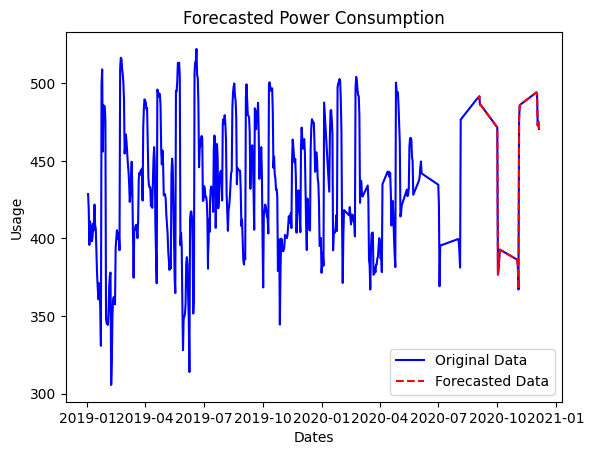

In [88]:
forecasted_steps = 20


plt.plot(demand_df['Dates'],demand_df['Usage'],label='Original Data',color='blue')
plt.plot(demand_df['Dates'][-forecasted_steps::],demand_df['Usage'][-forecasted_steps:],label='Forecasted Data',color='Red',linestyle='--')
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Usage')
plt.title('Forecasted Power Consumption')
plt.savefig('forecasted_power_consumption.png')
plt.show()

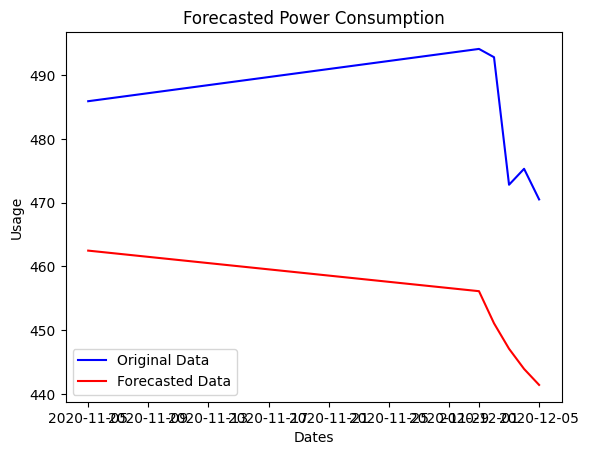

In [62]:
#plotting the linear plot for forecasting
plt.plot(demand_df['Dates'],demand_df['Usage'],label='Original Data',color='blue')
plt.plot(demand_df['Dates'],demand_df['Future_Usage'],label='Forecasted Data',color='Red')
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Usage')
plt.title('Forecasted Power Consumption')
plt.savefig('forecasted_power_consumption.png')
plt.show()

In [28]:
y_prediction_result = model_fit.predict(start=len(demand_df),end=len(demand_df)+20)

print(y_prediction_result)

503    462.486061
504    456.140258
505    451.115361
506    447.136418
507    443.985709
508    441.490833
509    439.515277
510    437.950941
511    436.712229
512    435.731360
513    434.954662
514    434.339638
515    433.852634
516    433.467002
517    433.161640
518    432.919841
519    432.728374
520    432.576761
521    432.456707
522    432.361643
523    432.286367
Name: predicted_mean, dtype: float64
